# Исследование игровых платформ <a class="anchor" id="ис_иг"></a>

## Оглавление
* [Открытие и изучение данных](#от_из)
* [Предобработка данных ](#пр_да)
    * [Замена названий столбцов](#за_на)
    * [Преобразование типов данных и форматов столбцов ](#пр_ти)
    * [Проверка на дупликаты ](#пр_на)
    * [Суммарные продажи](#су_пр)
* [Исследовательский анализ данных ](#ис_ан)
    * [Анализ выпуска игр по годам ](#ан_вы)
    * [Актуальные данные](#ак_да)
    * [Определение потенциально прибыльных платформ](#оп_по)
    * [Анализ потенциально прибыльных платформ](#ан_по)
    * [Анализ корреляции между отзывами и продажами ](#ан_ко)
    * [Анализ продаж по жанрам ](#ан_пр)
    * [Вывод](#в1)
* [Портрет пользователя по регионам](#по_по)
    * [Распределение продаж по платформам](#ра_по1)
    * [Распределение продаж по жанрам](#ра_по2)
    * [Распределение продаж по рейтингу](#ра_по3)
    * [Вывод ](#в2)
* [Проверка гипотез](#пр_ги)
    * [Средние пользовательские рейтинги платформ XOne и PC равны ](#ср_по)
    * [Средние продажи жанров Platform и Sports равны](#ср_пр)
* [Итоговые выводы](#ит_вы)

## Открытие и изучение данных <a class="anchor" id="от_из"></a>

Импортируем нужные библиотеки и установим игнорирование предупреждений.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from IPython.display import Markdown, display 

In [2]:
import warnings
warnings.filterwarnings('ignore')

Откроем датасет, сохраним в `data` и посмотрим на данные.

In [3]:
data = pd.read_csv('datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Много пропусков. Оценим более точно их количетсво.

In [5]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (100 * report['missing_values'] / data.shape[0]).round(2)
report[report['missing_values'] > 0].sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
Critic_Score,8578,51.32
Rating,6766,40.48
User_Score,6701,40.09
Year_of_Release,269,1.61
Name,2,0.01
Genre,2,0.01


Замечания к данным:
* Названия столбцов не в нижнем регистре;
* `Year_of_Release` стоит привести к `int`, `Critic_Score` и `User_Score` привести к одному формату: `float` и значения от 0 до 10, посмотреть, почему данные `User_Score` имеют тип `object`;
* много пропусков в `Critic_Score`, `User_Score` и `Rating`, которые мы скорее всего не сможем заполнить из-за их большого количества;
* небольшое количество пропусков в `Year_of_Release` и `Genre`;
* стоит добавить столбец `total_sales` с информацией об общей выручке плафтормы со всех регионов.

Недостатки в данных выделены, приступим к предобработке данных для анализа. 

## Предобработка данных <a class="anchor" id="пр_да"></a>

Устраним выявленные замечания.

### Замена названий столбцов <a class="anchor" id="за_на"></a>

Приведём названия столбцов к нижнему регистру.

In [6]:
data.columns = [x.lower() for x in data.columns]
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типов данных и форматов столбцов <a class="anchor" id="пр_ти"></a>

`Year_of_Release` переведём в формат `int`.

In [7]:
data = data.astype({'year_of_release': "Int64"})

Приведём оценки `critic_score` к диапазону от 0 до 10.

In [8]:
data['critic_score'] /= 10

Посмотрим, какие данные лежат в `user_score`.

In [9]:
[i for i in data.user_score.dropna().unique() if any(c.isalpha() for c in str(i))]

['tbd']

`tbd` означает "To Be Determined" - то есть "оценка будет определена позже". По смыслу это ничем не отличается от пропуска.

In [10]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

Теперь `user_score` и `critic_score` приведём к `float`.

In [11]:
data = data.astype({'user_score': "float"})
data = data.astype({'critic_score': "float"})

Заменим пропуски в столбце `rating` и `genre` на `unknown`.

In [12]:
data['rating'] = data['rating'].fillna('unknown')
data['genre'] = data['genre'].fillna('unknown')

### Проверка на дупликаты <a class="anchor" id="пр_на"></a>

Выполним проверку на дупликаты.

In [13]:
data.duplicated().sum()

0

### Суммарные продажи <a class="anchor" id="су_пр"></a>

Посчитаем суммарные продажи во всех регионах.

In [14]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Предобработка данных выполнена, можно приступать к исследовательскому анализу.

## Исследовательский анализ данных <a class="anchor" id="ис_ан"></a>

Для исследования нам предоставленны данные за период от 1980 года. За это время сменилось множество трендов, многие платформы прекратили своё существование, у пользователей сменились вкусы по жанрам, поэтому необходимо выделить "актуальный период". После этого в первую очередь нужно выбрать самые популярные платформы, затем посмотреть как влияют оценки и жанр игры на продажи.

### Анализ выпуска игр по годам <a class="anchor" id="ан_вы"></a>

Построим график распределения выпущенных игр и суммарных продаж по годам, исключив пропуски по годам выпуска.

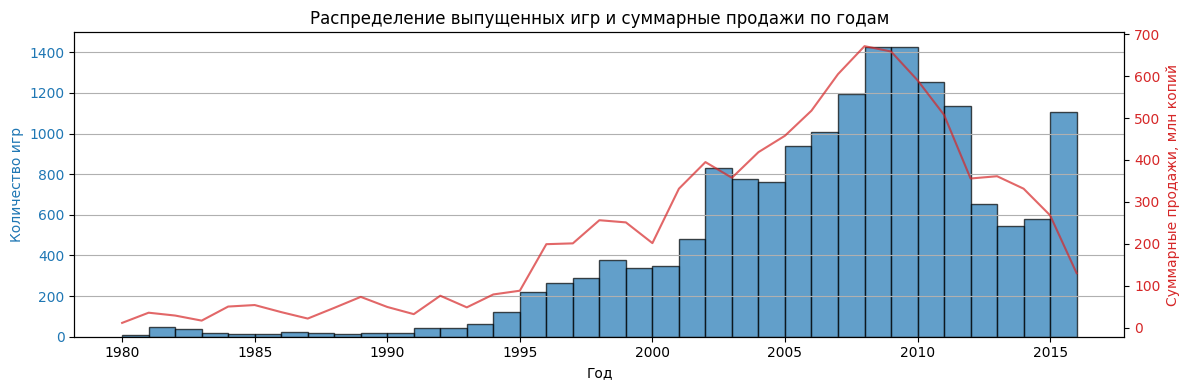

In [15]:
data_no_nan = data.dropna(subset='year_of_release')

fig, ax1 = plt.subplots(figsize=(12, 4))
color = 'tab:blue'
ax1.hist(data_no_nan['year_of_release'], bins=36, edgecolor='black', alpha=0.7, color=color)
ax1.set_xlabel('Год')
ax1.set_ylabel('Количество игр', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='y', linestyle='-')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.plot(data_no_nan.groupby('year_of_release')['total_sales'].sum(), alpha=0.7, color=color)
ax2.set_ylabel('Суммарные продажи, млн копий', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Распределение выпущенных игр и суммарные продажи по годам')
fig.tight_layout()  
plt.show()

Из графика видно, что пик выпускаемых игр пришёлся на 2005 - 2010 года, после этого периода наметился стабильный тренд на сокращение количества игр и продаж. Скорее всего сказались следующие факторы:
* Кризис 2008 года. Спад продаж нового поколения консолей привёл к сокращению потенциального рынка сбыта. Многие крупные студии, такие как EA, THQ, Midway Games потеряли в цене, их акции упали и студиям пришлось сокращать штат и реорганизовывать офисы.
* Смена стратегии. Компании стали ориентироваться на игры по подписке, например представителей жанра ММО РПГ. Такие игры выходят один раз и очень долго остаются востребованными.
* Переориентирование пользователей на мобильные платформы, которые не отображены в наших данных.
* Так же не стоит забывать, что продажи соотносены с годом выпуска игры. Свежие игры просто ещё не успели набрать свои продажи.

Эти выводы только подтверждают необходимость выделения актуального периода из всех данных. Посчитаем среднее время жизни платформы, выделив самые популярные платформы по продажам.

In [16]:
top_platforms = (
    data[['platform','year_of_release','total_sales']].pivot_table(
        index='platform',
        aggfunc={'total_sales':'sum',
                 'year_of_release':[np.min,np.max,lambda x: np.max(x)-np.min(x)+1]}
    ).droplevel(0,axis=1).rename(
        columns = {'amin':'year_first',
                   'amax':'year_last',
                   '<lambda_0>':'lifetime', 'sum':'total_sales'}
    ).sort_values(by='total_sales', ascending=False)
)
top_platforms.head(10)

,total_sales,lifetime,year_last,year_first
platform,,,,
PS2,1255.77,12,2011,2000
X360,971.42,12,2016,2005
PS3,939.65,11,2016,2006
Wii,907.51,11,2016,2006
DS,806.12,29,2013,1985
PS,730.86,10,2003,1994
GBA,317.85,8,2007,2000
PS4,314.14,4,2016,2013
PSP,294.05,12,2015,2004


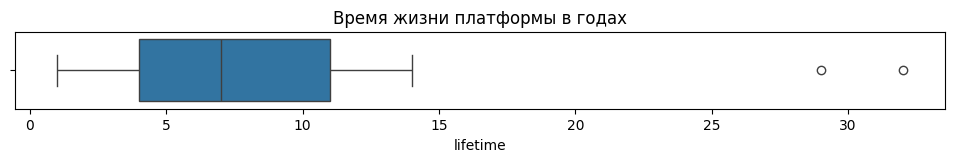

Среднее время жизни платформы в годах: 8.61


In [17]:
plt.figure(figsize=(12,1))
sns.boxplot(x=top_platforms['lifetime']);
plt.title('Время жизни платформы в годах')
plt.show()
print(f'Среднее время жизни платформы в годах:', top_platforms['lifetime'].mean().round(2))

Почти **9 лет**. Не так уж и много. Выбирая актуальный период стоит предположить, что нас интересуют платформы, которые ещё некоторое время будут активными после 2017 года. Поэтому определим актуальный период с 2012 года, обновим топ самых популярных платформ и построим графики продаж. Отдельно стоит выделить **PC** - самая долгоживущая платформа, игры на которой представленны во всём временном промежутке от 1985 года.

**Дальнейшие выкладки основаны на данных от 2012 года включительно**

### Актуальные данные <a class="anchor" id="ак_да"></a>

Сделаем срез данных от 2012 года включительно, посчитаем общие продажи для каждой платформы и выберем топ-10 самых популярных.

In [18]:
data_actual = data.query('year_of_release >= 2012')

In [19]:
top_platforms = data_actual[['platform', 'total_sales']].pivot_table(
    index='platform',
    aggfunc={'total_sales':'sum'}
).sort_values(by='total_sales', ascending=False).head(10)

top_platforms

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


Теперь посчитаем продажи для каждой из топ-10 платформы по годам.

In [20]:
data_pivot_sales = data_actual.query('platform in @top_platforms.index').pivot_table(
    index='platform',
    values='total_sales',
    columns='year_of_release',
    aggfunc='sum'
).fillna(0)

display(data_pivot_sales)

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
DS,11.01,1.54,0.00,0.00,0.00
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.36,113.25,47.76,16.82,3.60
PS4,0.00,25.99,100.00,118.90,69.25
PSV,16.19,10.59,11.90,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.60
X360,99.74,88.58,34.74,11.96,1.52


С этими данными можно определить потенциально прибыльные платформы.

### Определение потенциально прибыльных платформ <a class="anchor" id="оп_по"></a>

Построим график по данным о продажах.

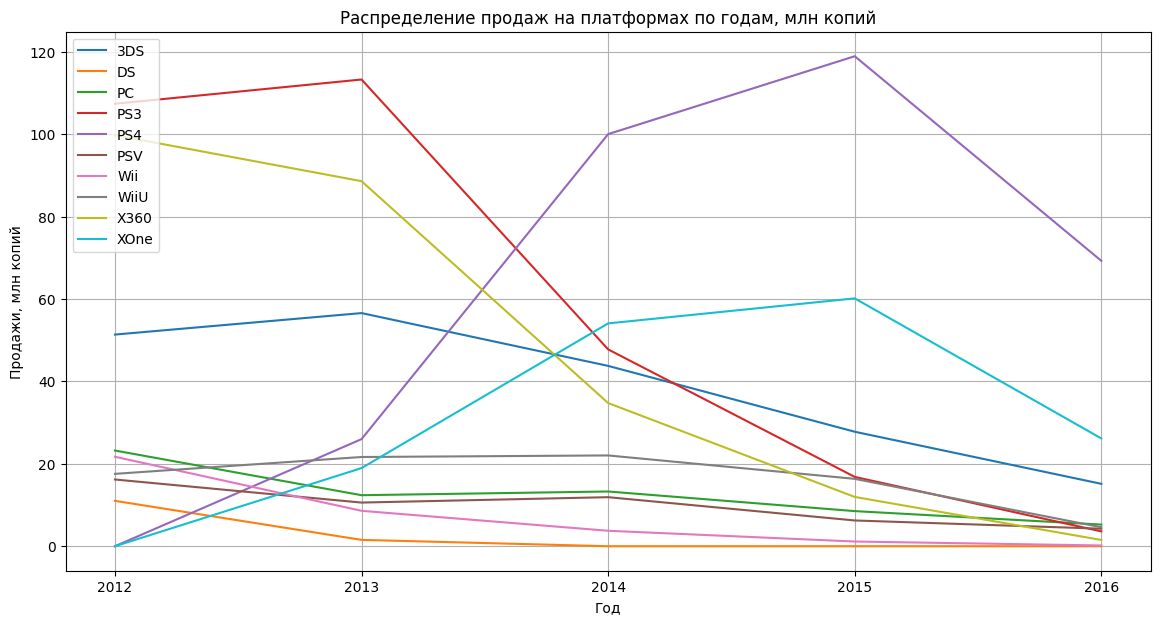

In [21]:
data_pivot_sales.T.plot(figsize=(14, 7))
plt.xticks([2012, 2013, 2014, 2015, 2016])
plt.title('Распределение продаж на платформах по годам, млн копий')
plt.xlabel('Год')
plt.ylabel('Продажи, млн копий')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Таким образом можно заключить:

* **PS3** и **X360** не смотря на большую популярность в прошлом теперь в аутсайдерах, их вытеснили платформы нового поколения, а учитывая частичную совместимость игры с платформами будущих поколений, данные платформы стоит исключить из анализа.
* На фоне общего ниспадающего тренда лучше всего себя показывают **PS4**, **XOne** и **3DS**. Стоит отметить, что самая старая из них **3DS** скоро приблизится к средней продолжительности жизни платформы.
* Так же стоит рассмотреть **PC**, которая показывает более стабильную динамику и очень маловероятно потеряет актуальность в ближайшее время, и **WiiU** с такой же неплохой стабильной динаминой.
* **DS**, **Wii** и **PSV** уже не представляют интереса для использования в рекламной кампании.

### Анализ потенциально прибыльных платформ <a class="anchor" id="ан_по"></a>

Проанализируем продажи потенциально прибыльных платформ

In [22]:
potential_platform = ['PS4', 'XOne', '3DS', 'WiiU', 'PC']
data_actual = data_actual.query('platform in @potential_platform').reset_index(drop=True)

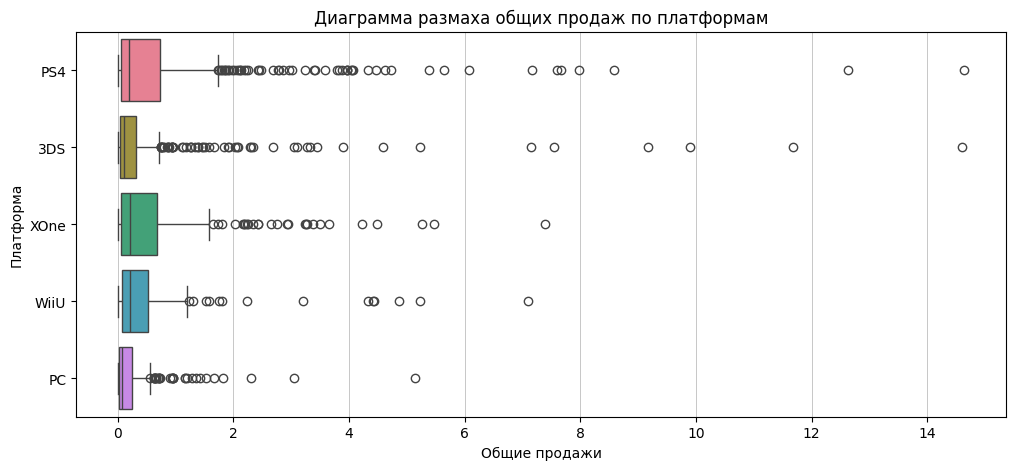

In [23]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='total_sales', y='platform', data=data_actual, palette='husl')
plt.xlabel('Общие продажи')
plt.ylabel('Платформа')
plt.title('Диаграмма размаха общих продаж по платформам')
plt.grid(axis='x', linestyle='-', linewidth=0.5)
plt.show()

1. Ожидаемо распределения скошенны вправо, непопулярных проектов намного больше, чем популярных.
2. Обычно неприятные для анализа выбросы в данном случае наоборот несут важное значение - это игры, которые стали хитами. Поэтому платформы, с наибольшим количеством таких хитов наиболее привлекательны для выбора их игр для рекламной кампании. Посмотрим на средние и медиану.

In [24]:
data_actual.groupby('platform')['total_sales'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.49,1.39,0.01,0.04,0.11,0.31,14.60
PC,250.0,0.25,0.49,0.01,0.03,0.08,0.24,5.14
PS4,392.0,0.80,1.61,0.01,0.06,0.20,0.73,14.63
WiiU,147.0,0.56,1.06,0.01,0.08,0.22,0.52,7.09
XOne,247.0,0.65,1.04,0.01,0.06,0.22,0.68,7.39


Проекты, выпущенные на **PS4** имеют наилучшие показатели средних продаж - **0.8 млн копий** на игру. Самое большое отношение среднего к медиане у **PS4** и **XOne**. Это говорит о том, что хиты на этих платформах вносят значительный вклад в продажи.

Посмотрим на другие факторы, влияющие на популярность игры.

### Анализ корреляции между отзывами и продажами <a class="anchor" id="ан_ко"></a>

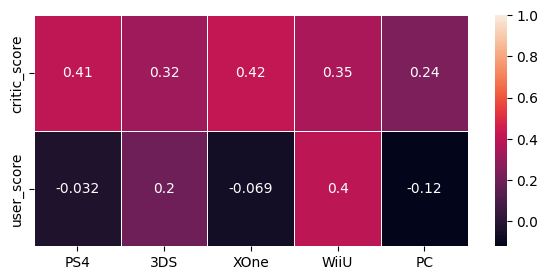

In [25]:
corr_data = pd.DataFrame()
for platform in data_actual['platform']:
    df_p = data_actual.query("platform==@platform")
    corr_data[platform] = df_p[['critic_score', 'user_score']].corrwith(df_p['total_sales'])

plt.figure(figsize=(7, 3))
sns.heatmap(corr_data, annot=True, linewidth=.5, vmax=1);

Больше всего отзывы критиков влияют на продажи самых популярных консолей **PC** и **XOne** и, что интересно, на продажи **PC**. Отзывы пользователей наоборот - практически не влияют на продажи. В случае с менее популярными платформами **3DS**, **WiiU** влияние отзывов пользователей сравнимо с влиянием отзывов критиков. Возможно, дело не в популярности платформы, а в регионе выпуска/использования, так как **3DS** и **WiiU** это игровые консоли **Nintendo**, японской фирмы . Посмотрим на диаграмму рассеяния для **PS4**.

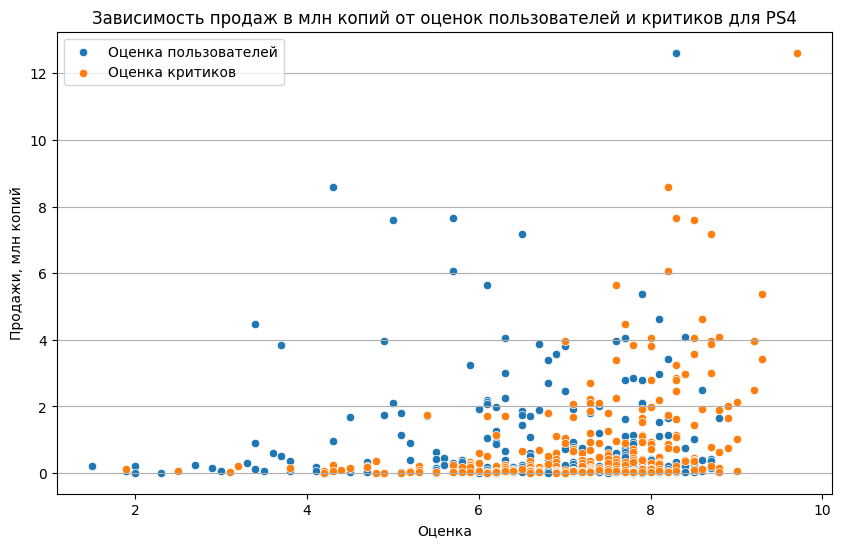

In [26]:
selected_platform = 'PS4'

selected_platform_data = data_actual[data_actual['platform'] == selected_platform]

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=selected_platform_data, x="user_score", y="total_sales", label="Оценка пользователей")
ax = sns.scatterplot(data=selected_platform_data, x="critic_score", y="total_sales", label="Оценка критиков")
ax.set_title('Зависимость продаж в млн копий от оценок пользователей и критиков для ' + selected_platform)
plt.xlabel('Оценка')
plt.ylabel('Продажи, млн копий')
plt.legend()
plt.grid(axis='y')
plt.show()

In [27]:
data_actual[['critic_score', 'user_score']].describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
critic_score,813.0,7.282,1.246,1.9,6.7,7.5,8.1,9.7
user_score,859.0,6.680,1.507,1.4,5.9,7.0,7.8,9.3


Видно, что критики ставят оценки чуть выше, нежели пользователи. Можно заключить, что:
* Если у игры низкая оценка пользователей или критиков, то она скорее всего будет продоваться плохо.
* Присутствует небольшая корреляция между оценками критиков и продажами игры и, начиная примерно с 8.5 баллов, **чем выше оценки критиков - тем выше средние продажи и сильнее корреляция**.
* Оценка пользователей практически не коррелирует с продажами.
* Пользователи ставят более критичные оценки, нежели критики.

Посмотрим диаграммы рассеяния для других платформ.

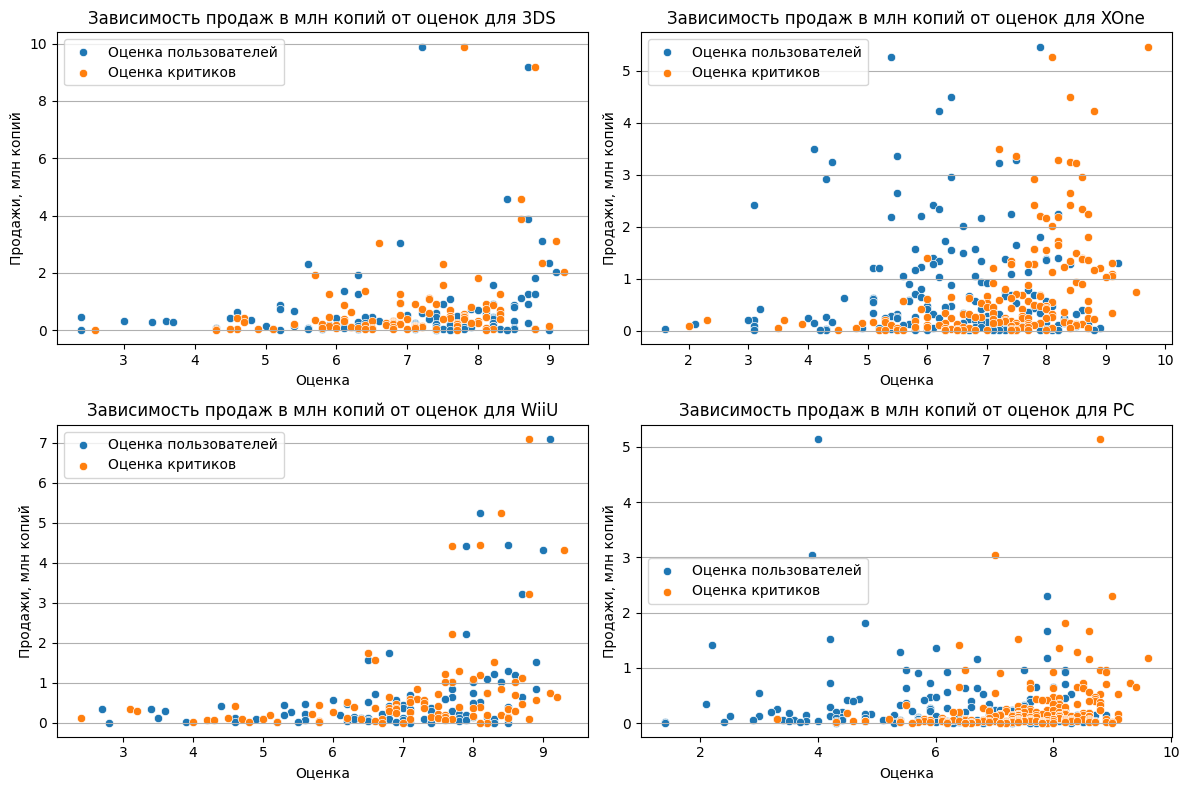

In [28]:
selected_platforms = ['3DS', 'XOne', 'WiiU', 'PC']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, platform in enumerate(selected_platforms):
    row = i // 2
    col = i % 2
    
    selected_platform_data = data_actual[data_actual['platform'] == platform]
    ax = axs[row, col]
    ax = sns.scatterplot(data=selected_platform_data, x="user_score", y="total_sales", label="Оценка пользователей", ax=ax)
    ax = sns.scatterplot(data=selected_platform_data, x="critic_score", y="total_sales", label="Оценка критиков", ax=ax)
    ax.set_title('Зависимость продаж в млн копий от оценок для ' + platform)
    ax.set_xlabel('Оценка')
    ax.set_ylabel('Продажи, млн копий')
    ax.legend()
    ax.grid(axis='y')
    
plt.tight_layout()
plt.show()

Выводы для **PS4** верны и для остальных платформ. Кроме того похоже, что *средние пользовательские рейтинги платформ **XOne** и **PC** равны*. Сформулируем гипотезу и проверим её перед окончательным выводом.

### Анализ продаж по жанрам <a class="anchor" id="ан_пр"></a>

Для анализа продаж по жанрам стоит выделить медианные продажи, так как именно они наилучшим образом характеризуют успешность игр в данном жанре. Дополнительно посмотрим на общее количество продаж в жанре.

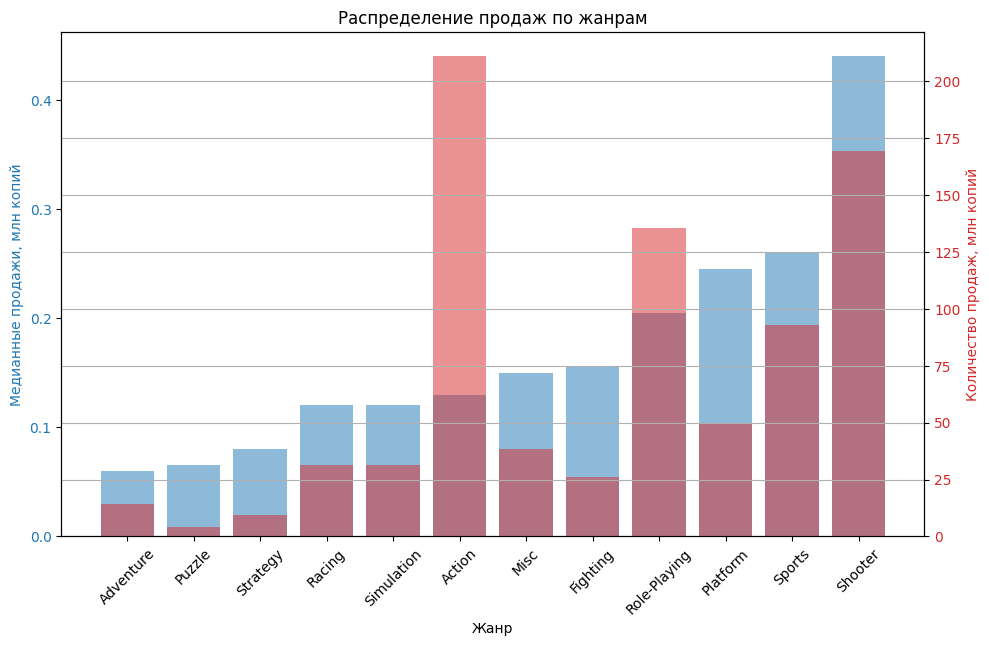

In [29]:
genre_sales_data = data_actual.pivot_table(index='genre', values='total_sales', aggfunc=('sum', 'median')).sort_values(by='median', ascending=True).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_title('Распределение продаж по жанрам')
ax1.set_xlabel('Жанр')
ax1.set_ylabel('Медианные продажи, млн копий', color=color)
ax1.bar(genre_sales_data['genre'], genre_sales_data['median'], color=color, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Количество продаж, млн копий', color=color)  
ax2.bar(genre_sales_data['genre'], genre_sales_data['sum'], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
ax1.set_xticklabels(genre_sales_data['genre'], rotation=45)
plt.grid(axis='y')
plt.show()

* Игры в жанрах **Shooter**, **Platform**, **Sports** и **Role-Playing** наиболее прибыльны.
* Среди всех остальные выделяется **Action** - очень много продаж, но медиана не выразительная.
* Наименее прибыльные жанры - **Strategy**, **Adventure**, **Puzzle**

Ещё отметим, что медианные продажи у **Platform** и **Sports** выглядят одинаковыми. Выдвенем предположение, что и *средние продажи этих жанров равны*. Так же сформулируем гипотезу и проверим её перед окончательным выводом.

### Вывод <a class="anchor" id="в1"></a>

* Средняя продолжительность существования платформы - 9 лет, поэтому данные до 2012 были признаны не актуальными. Самая долгоживущая платформа - **PC**. Игры на ней представленны во всём временном промежутке от 1985 года.
* Для дальнейшего анализа выбраны **PS4**, **XOne**, **3DS**, **WiiU** и **PC**. Исходя из анализа распределения общих продаж на платформах рекомендуется в первую очердь обратить внимание на **PS4**, после - на **XOne**.
* Отзывы критиков одинаково важны для всех платформ, однако отзывы пользоваталей имеют вес только для **3DS** и **WiiU**. Если отзывы критиков больше 8.5, то скорее всего проект будет действительно хорошо продаваться. Оценки ниже 6 как от критиков, так и от пользователей скорее всего характеризуют игру как неуспешную.
* Игры в жанрах **Shooter**, **Platform**, **Sports** и **Role-Playing** наиболее популярны. Наименее прибыльные жанры - **Strategy**, **Adventure**, **Puzzle**.

## Портрет пользователя по регионам <a class="anchor" id="по_по"></a>

Для составления портрета пользователя по регионам нужно выделить популярность платформ в регионах, продажи по жанрам и влияние рейтинга на продажи. Используем `pd.plot(kind='bar')`, обёрнутый в функцию.

In [30]:
def pivot_plot(index):
    platform_sales_data = data_actual.pivot_table(index=index, values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').sort_values(by=['na_sales', 'eu_sales', 'jp_sales'], ascending=True).reset_index()
    platform_sales_data.set_index(index, inplace=True)
    platform_sales_data.plot(kind='bar', figsize=(14, 6));
    plt.title(f'Распределение продаж по {index}, млн копий')
    plt.xlabel(f'{index}')
    plt.ylabel('Продажи, млн копий')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Распределение продаж по платформам <a class="anchor" id="ра_по1"></a>

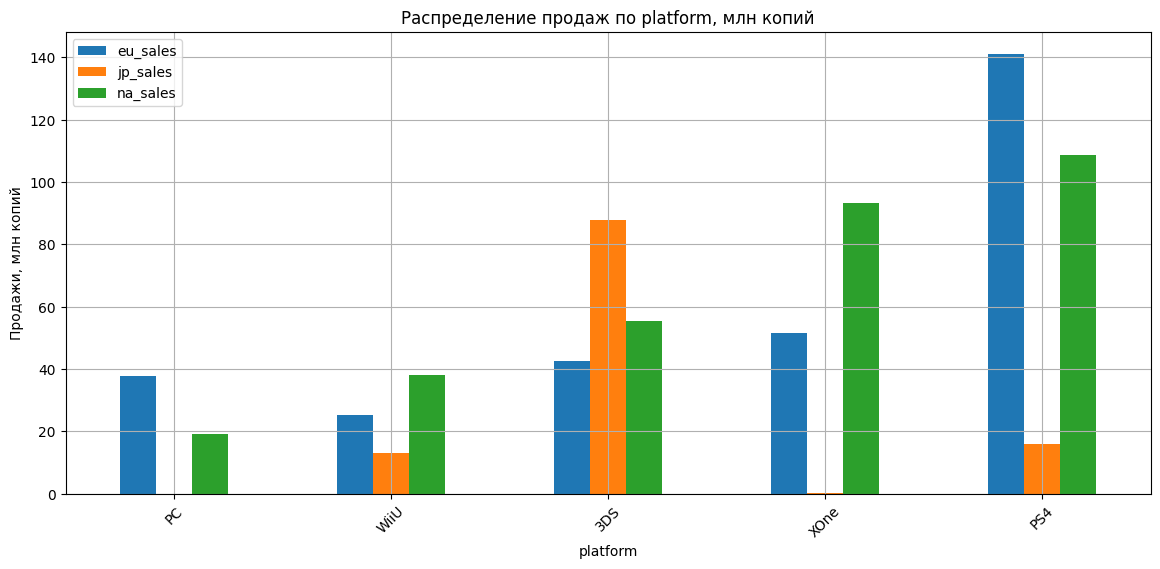

In [31]:
pivot_plot('platform')

* В Америке топ-3 по популярности платформы **PS4**, **XOne** и **3DS**, менее всего популярна - **WiiU**.
* В Европе показатели очень схожи с Америкой с той разницей, что **PS4** имеет более значительный отрыв от остальных плафторм, а **PC** популярнее, чем **3DS** и **XOne**. 
* В Японии пользуются практически только **3DS**.

### Распределение продаж по жанрам <a class="anchor" id="ра_по2"></a>

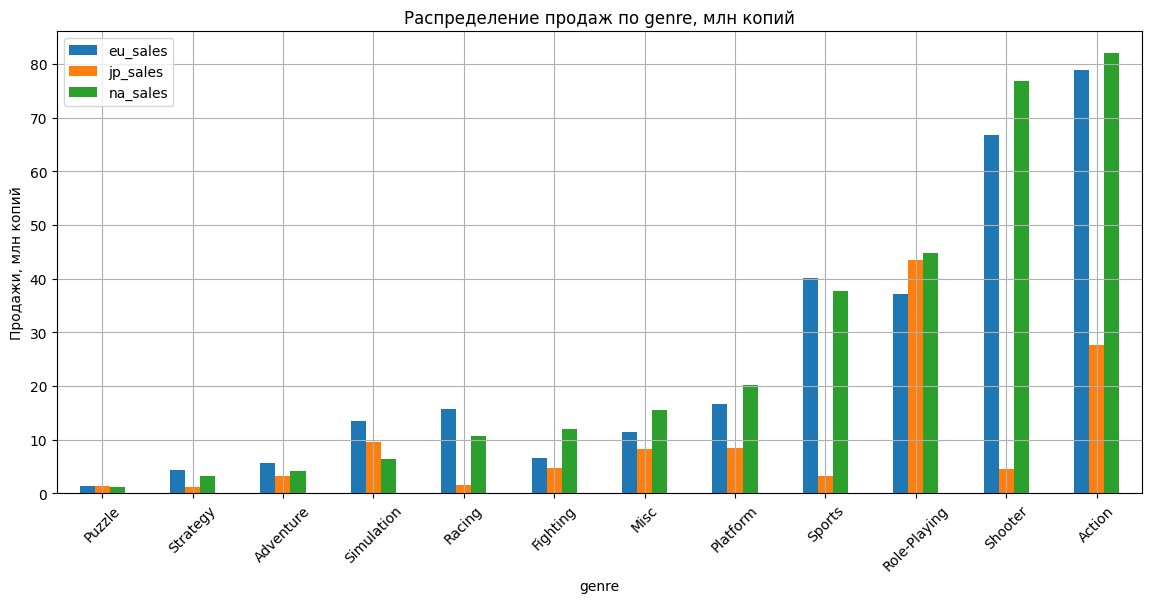

In [32]:
pivot_plot('genre')

* Жанры для Америки и Европы довольно сильно совпадают, самые популярные - **Action**, **Shooter**, **Role-Playing**. Наименее популярные - **Puzzle**, **Adventure**, **Strategy**.
* В Японии с большим отрывом лидирует **Role-Playing**, после него идёт **Action**.

### Распределение продаж по рейтингу <a class="anchor" id="ра_по3"></a>

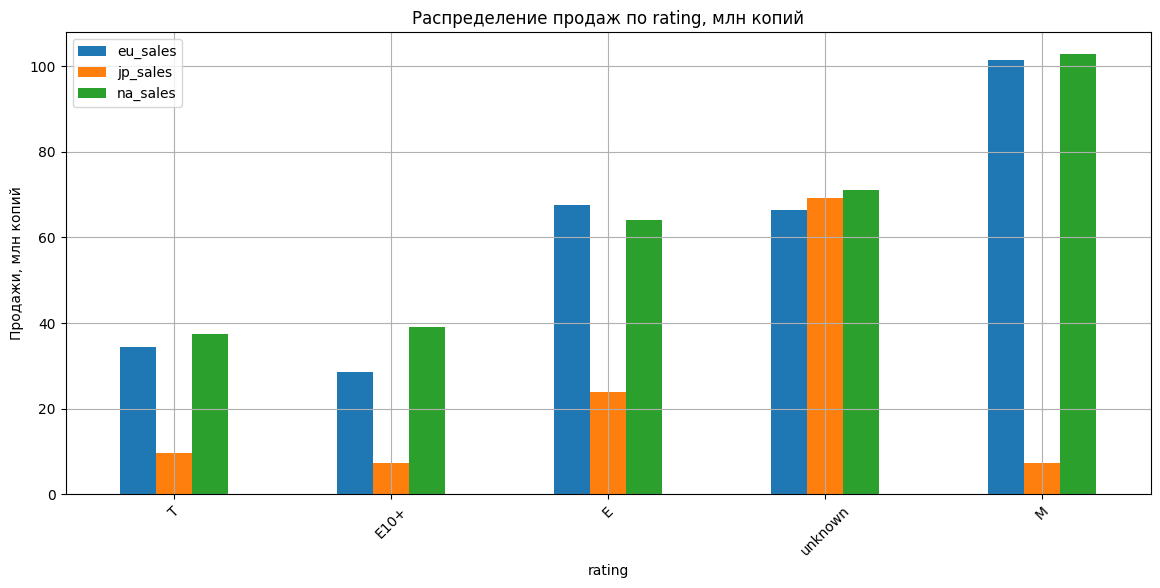

In [33]:
pivot_plot('rating')

* В Европе и Америке самый больше всего продаж приходится на рейтинг **M** "Для взрослых", за ним идёт **E** "Для всех".
* Рейтинги в Японии зачастую не указаны. Возможно много игр выходит для внутреннего рынка. Из того что известно рейтин **E** "Для всех" самый популярный.

### Вывод <a class="anchor" id="в2"></a>

Исходя из объёмов продаж следует выделить два рынка : в один объединить Европу и Северную Америку, в другой отнести Японию. Для первого характерная игра будет выглядеть как **Action** или **Shooter** на платформе **PS4** или **XOne** с рейтингом **M**, для второго - **Role-Playing** на платформе **3DS**. Стоит отметить, что  **Role-Playing** на платформе **3DS** может иметь некоторый спрос и в первом регионе.

## Проверка гипотез <a class="anchor" id="пр_ги"></a>

У нас есть два предположения:
1. Средние пользовательские рейтинги платформ **XOne** и **PC** равны.
2. Средние продажи жанров **Platform** и **Sports** равны.

Проверим их с помощью *t-теста*, сформулировав нулевую и альтернативные гипотезы, сравнив дисперсии распределений, и установив критический уровень статистической значимости `alpha = .05`.

### Средние пользовательские рейтинги платформ XOne и PC равны <a class="anchor" id="ср_по"></a>

* **H0** (Нулевая гипотеза): Средние пользовательские рейтинги платформ Xbox One и PС равны
* **Н1** (Альтернативная гипотеза) : Средние пользовательские рейтинги платформ Xbox One и PС различаются

Сравним дисперсии распределений.

In [34]:
def variance(data, col1, col2, a, b):
    var1 = np.var(data.query(f"{col1} == '{a}'")[col2])
    var2 = np.var(data.query(f"{col1} == '{b}'")[col2])
    print(f'Дисперсия {a} {var1.round(3)} и {b} {var2.round(3)}')

In [35]:
variance(data_actual, 'platform', 'user_score', 'PC', 'XOne')

Дисперсия PC 2.757 и XOne 1.897


Так как дисперсии отличаются незначительно, то будем считать `equal_val = True`.

In [36]:
alpha = .05

pvalue = st.ttest_ind(data_actual.query("platform == 'XOne'")['user_score'].dropna(), 
                      data_actual.query("platform == 'PC'")['user_score'].dropna(),  
                      ).pvalue

display('p-значение:  {:.2%}'.format(pvalue))

if pvalue < alpha:
    display(Markdown("Принимаем альтернативную гипотезу: *средние пользовательские рейтинги платформ **XOne** и **PC** **не равны.***"))
else:
    display(Markdown("Принимаем нулевую гипотезу: *cредние пользовательские рейтинги платформ **XOne** и **PC** **равны.***"))

'p-значение:  55.35%'

Принимаем нулевую гипотезу: *cредние пользовательские рейтинги платформ **XOne** и **PC** **равны.***

### Средние продажи жанров Platform и Sports равны <a class="anchor" id="ср_пр"></a>

* **H0** (Нулевая гипотеза): Cредние продажи жанров **Platform** и **Sports** равны
* **Н1** Альтернативная гипотеза) : редние продажи жанров **Platform** и **Sports** различаются

Сравним дисперсии распределений.

In [37]:
variance(data_actual, 'genre', 'total_sales', 'Platform', 'Sports')

Дисперсия Platform 2.585 и Sports 1.772


Отличие дисперсий в два раза приемлимо для того, чтобы оставить `equal_val = True`.

In [38]:
alpha = .05

pvalue = st.ttest_ind(data_actual.query("genre == 'Platform'")['total_sales'].dropna(), 
                      data_actual.query("genre == 'Sports'")['total_sales'].dropna()).pvalue

display('p-значение:  {:.2%}'.format(pvalue))

if pvalue < alpha:
    display(Markdown("Принимаем альтернативную гипотезу: *средние продажи жанров Platform и Sports **не равны.***"))
else:
    display(Markdown("Принимаем нулевую гипотезу: *cредние продажи жанров Platform и Sports **равны.***"))

'p-значение:  62.45%'

Принимаем нулевую гипотезу: *cредние продажи жанров Platform и Sports **равны.***

## Итоговые выводы <a class="anchor" id="ит_вы"></a>

Предоставленные данные имели недостатки, самым значимым являлось большое количество пропусков, которое невозможно было устранить, не повлияв на распределения.
Основные выводы, которые можно сделать по итогам исследования:
* Средняя продолжительность существования платформы - 9 лет.
* Актуальный для исследования период - с 2012 года.
* Отзывы критиков одинаково важны для всех платформ, однако отзывы пользоваталей имеют вес только для **3DS** и **WiiU**. Если отзывы критиков больше 8.5, то скорее всего проект будет действительно хорошо продаваться. Оценки ниже 6 как от критиков, так и от пользователей скорее всего характеризуют игру как неуспешную.

**По жанрам и играм в целом**:
* Платформы **PS4**, **XOne**, **3DS**, **WiiU** и **PC** лидируют по продажам. **PS4** имеет самый значимый вклад хитов в продажи. **PC** явлется самой долгоживущей платформой и сохраняет актуальность с 1985 года.
* Игры в жанрах **Shooter**, **Platform**, **Sports** и **Role-Playing** наиболее популярны. Наименее прибыльные жанры - **Strategy**, **Adventure**, **Puzzle**.

**Портет пользователя по регионам выглядит примерно так**:
* Для Европы и Северной Америки пользователи предпочитают **Action** или **Shooter** на платформе **PS4** или **XOne** с рейтингом **M**, для Японии - **Role-Playing** на платформе **3DS**.

**Проверка гипотез показала**:
* Средние пользовательские рейтинги платформ **XOne** и **PC** **равны**.
* Средние продажи жанров **Platform** и **Sports** **равны**.